# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [93]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os.path
import datetime as dt
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [94]:
class ImgViewer:
    # for debug - usage demo
    #    
    #    binary_warped = mpimg.imread('test_images/test1.jpg')
    #    imgViewer = ImgViewer(30, 30)
    #    for i in range(1,10):
    #        imgViewer.push(binary_warped, "some_title' + str(i))

    #    
    def __init__(self, w, h):
        self.img_parms_list = []
        self.w = w
        self.h = h

    def push(self, img_ref, title="larry"):
        self.img_parms_list.append({'img_ref' : img_ref, 'title' : title})

    def show(self,  cols = 2):
        if  len(self.img_parms_list) < 1:
            raise Exception("nothing to show")
        rows = int(np.ceil(len(self.img_parms_list) / cols))
        #print("FIXME: rows = %d, cols = %d" % (rows, cols))
        
        fig = plt.figure(figsize=(self.w, self.h))
        for i , _img_parms in zip(range(1, len(self.img_parms_list) + 1), self.img_parms_list):
            img_ref = _img_parms['img_ref']
            ax = fig.add_subplot(rows, cols , i)
            ax.set_title(_img_parms['title'])
            plt.imshow(img_ref, cmap='Greys_r')
        plt.show()

    def flush(self):
        self.img_parms_list = []


In [95]:
class ImgSaver:
    # abstracts saving a bunch of files in a timestamp directory
    def __init__(self):
        d = "test_out/"
        d = d + dt.datetime.now().strftime("%a_%m%d%y_%H%M%S") + "/"
        self.outdir = d
        os.mkdir(d)

    def save(self, img, img_name, cmap='Greys_r', msg=""):
        outf = self.outdir + img_name + "_" + msg + ".png"
        if cmap:
            mpimg.imsave(outf, img, cmap=cmap)
        else:
            mpimg.imsave( outf, img)

In [96]:
def ohBother(img):
        plt.figure()
        plt.imshow(img)
        plt.show()
        
def ohBother_g(img):
        plt.figure()
        plt.imshow(img, cmap='Greys_r')
        plt.show()  

In [97]:
class PipeStage:

    def __init__(self, fn, hyper_parms):
        self.fn = fn
        self.hyper_parms = hyper_parms

    def exec(self, img, pipe_parms):
        return  self.fn(img)


class Pipe:

    def __init__(self, stage_list, parm_dict, viewer=None):
        self.stage_list = stage_list
        self.pipe_parm_dict = parm_dict
        try:
            self.imgViewer = parm_dict['viewer']
        except:
            self.imgViewer = ImgViewer(4,4)

    def exec(self, img):
        # unenforced convention img can also be a path for pipes where the
        # first stage reads an image from the path
        tmp = img
        for stage in self.stage_list:
            stage_name = stage.hyper_parms['name']
            print("stage: %s" % stage_name)
            tmp = stage.exec(tmp, None)

            none_type = type(None) # FIXME
            if type(tmp) != none_type: # stages must return img or None
                self.imgViewer.push(tmp, stage_name)
        self.imgViewer.show()


In [98]:
gViewer = ImgViewer(4,4)

In [99]:
def stage_fn_stub(img):
    print("boy howdy")
    return img

def stage_fn_img_read(path):
     img = mpimg.imread(path)
     return img

def stage_fn_rgb2gray(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return gray

In [100]:
demo_pipeline_1 = Pipe(
    [
        PipeStage(stage_fn_img_read,
                       {'name' : 'imgread', 'debug_level' : 2}),
        PipeStage(stage_fn_stub,
                       {'name' : 'stub1', 'debug_level' : 2}),
        PipeStage(stage_fn_stub,
                       {'name' : 'stub2', 'debug_level' : 2})
     ],
    {'debug_level ': 3})

In [101]:
demo_pipeline_2 = Pipe(
    [
        PipeStage(stage_fn_stub,
                       {'name' : 'stub1', 'debug_level' : 2}),
        PipeStage(stage_fn_stub,
                       {'name' : 'stub2', 'debug_level' : 2})
    ],
    {'debug_level ': 3})

In [102]:
demo_pipeline_3 = Pipe(
    [
        PipeStage(stage_fn_img_read,
                       {'name' : 'imgread', 'debug_level' : 2}),
        PipeStage(stage_fn_rgb2gray,
                       {'name' : 'stub2', 'debug_level' : 2})
    ],
    {'debug_level ': 3, 'viewer' : gViewer})

In [103]:
def calibrate_camera(viewer):
    
    for fname in glob.glob("camera_cal/*.jpg"):
        basename = os.path.basename(fname)
        img = None
        img = cv2.imread(fname)
        print("FIXME_2: shape = " + str(img.shape))
        plt.figure()
        plt.imshow(img)
        plt.show()
        viewer.push(mpimg.imread('camera_cal/calibration1.jpg'), "desperation")
        viewer.flush()
        viewer.push(img, "initial img")
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #viewer.push(gray, "initial img")
        print("FIXME:  exit loop")
        break
    viewer.show()
    print("FIXME:thats all folx")

FIXME_1: shape = (720, 1280, 3)


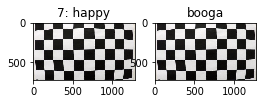

In [104]:
#demo_pipeline_1.exec('test_images/test1.jpg')
#demo_pipeline_2.exec(mpimg.imread('test_images/test1.jpg'))
#demo_pipeline_3.exec('camera_cal/calibration1.jpg')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = 'curly')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = 'moe')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = '1: sleepy')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = '2: sneezy')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = '3: doc')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = '4: dopey')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = '5: bashful')
#gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = '6: grumpy')
gViewer.push(mpimg.imread('camera_cal/calibration1.jpg'), title = '7: happy')
#
img = mpimg.imread('camera_cal/calibration1.jpg')
print("FIXME_1: shape = " + str(img.shape))
img = mpimg.imread('camera_cal/calibration1.jpg')
gViewer.push(img, "booga")
gViewer.show()
gViewer.flush()

FIXME_2: shape = (720, 1280, 3)


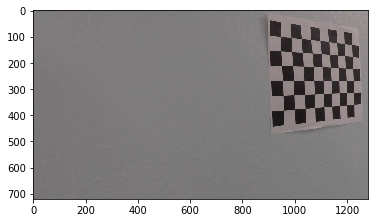

FIXME:  exit loop


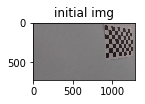

FIXME:thats all folx


In [105]:
calibrate_camera(gViewer)

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

Let's try the one with the solid white lane on the right first ...